# PHYS3070 2025: Linear Regression and Unceratinty Propagation

<a href="https://colab.research.google.com/github/tsonpham/InvProb/blob/master/Lec2_LinReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepared by Thanh-Son Pham (thanhson.pham@anu.edu.au), September 2025.

---
## What we do in this notebook:
- Least-squares regression and uncertainty estimate
- Goodness of fit and $p$-value
- Least 1-norm regression and Monte-Carlo error propagation

The next cell installs some library packages will be used in this notebook. It must be run on Google Colab to set up the working environment in the remote server (nothing will be installed on your computer).

In [2]:
#@title Run to activate retina display

%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 10

---
## The parabolic trajectory problem

Let's consider the prabolic trajectory problem (see Examples 1.1 and 2.1; Aster et al., 2019),
$$
y = m_0 + m_1 t - \frac{1}{2} m_2 t^2,
$$
where $m_0$ is the initial height, $m_1$ is the initial velocity, and $m_2$ is the gravitational acceleration.

Consider a synthetic data set with $m=10$ observations and inderpendent normal data errors ($\sigma = 8m$), generated using
$$
\mathbf{m}_{true} = [10 m, 100 m/s, 9.8 m/s^2]^T.
$$
The data $\mathbf{d} = [y_0, y_1, ... y_m]^T$ observed at $m$ time epochs $t_1, t_2, ... t_m$. The number of model parmeters $n=3$.

We construct the design matrix $\mathbf{G}$ as,
$$
\mathbf{G} = \left[\begin{matrix}
1 & t_1 & -\frac{1}{2} t_1^2\\
1 & t_2 & -\frac{1}{2} t_2^2\\
\ldots\\
1 & t_{10} & -\frac{1}{2} t_{m}^2\\
\end{matrix}\right]
$$

The forward problem is written in the linear form,
$$
\mathbf{d} =  \mathbf{G} \mathbf{m}.
$$

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(1)

sigma = 8
m_true = np.array([10, 100, 9.8])

## Independent, i.e. time, variable
t = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
## Design matrix
G = np.vstack((np.ones(t.shape), t, -0.5 * t**2)).T
## Synthetic data with random noise
y = m_true[0] + m_true[1] * t - 0.5 * m_true[2] * t**2 + np.random.normal(0, sigma, size=t.shape)

print (t)
print (np.round(y, 1))

[ 1  2  3  4  5  6  7  8  9 10]
[118.1 185.5 261.7 323.  394.4 415.2 483.9 490.3 515.7 518. ]


Next, we define a handy function to plot the synthetic dataset.

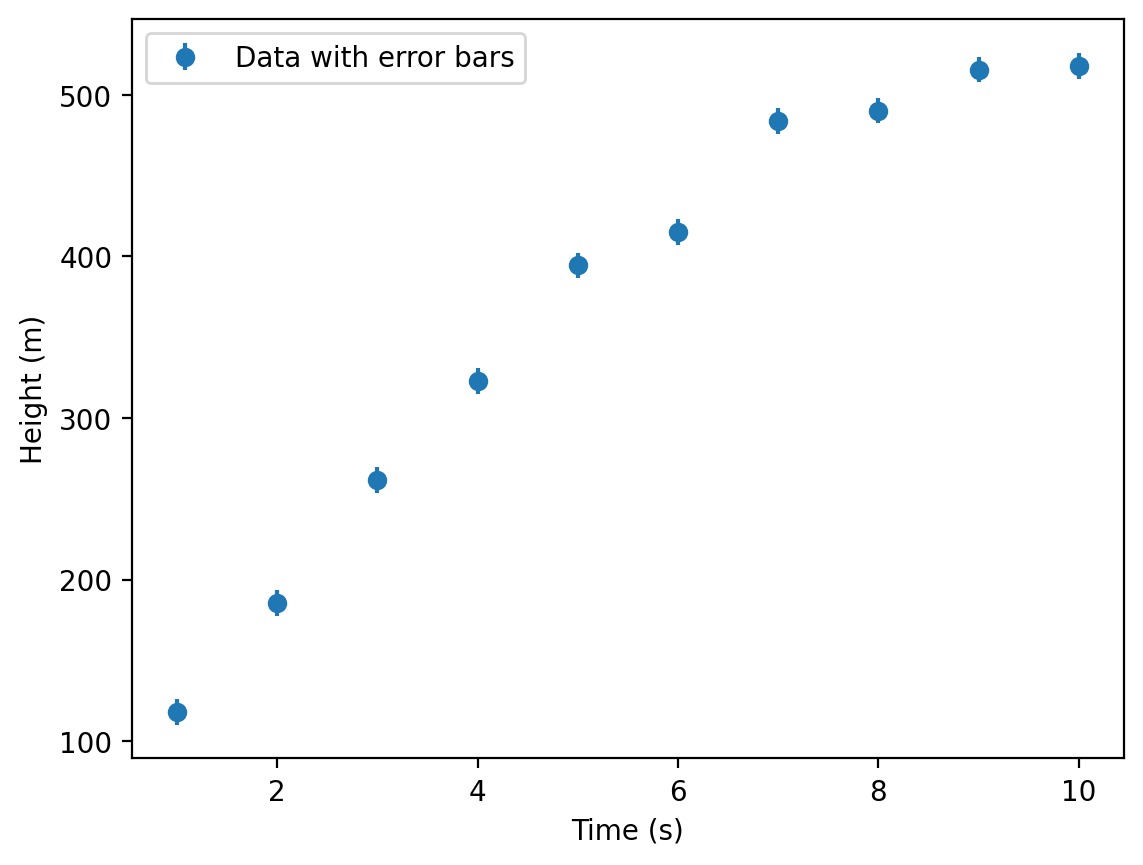

In [4]:
def plot_data(t, y, sigma):
    '''
    Plot the data with error bars.
    '''
    fig, ax = plt.subplots()
    ax.errorbar(t, y, sigma, fmt='o', label='Data with error bars')
    ax.set(xlabel='Time (s)', ylabel='Height (m)')
    return ax

## Plot data for visualization
ax = plot_data(t, y, sigma)
ax.legend()
plt.show()

---
## $L2$ regression

The least-squares solution of the linear forward problem defines,
$$
\mathbf{m}_{L2} = (\mathbf{G}^T \mathbf{G})^{-1} \mathbf{G}^T \mathbf{d},
$$
which minimizes the 2-norm misfit between observation and prediction,
$$
\min_{m_0, m_1, m_2} L = \sum_{i=1}^m \left(d_i - (m_0 + m_1 t - \frac{1}{2} m_2 t^2)\right)^2.
$$

Least Squares solution (2-norm): [19.3 95.5  9. ]


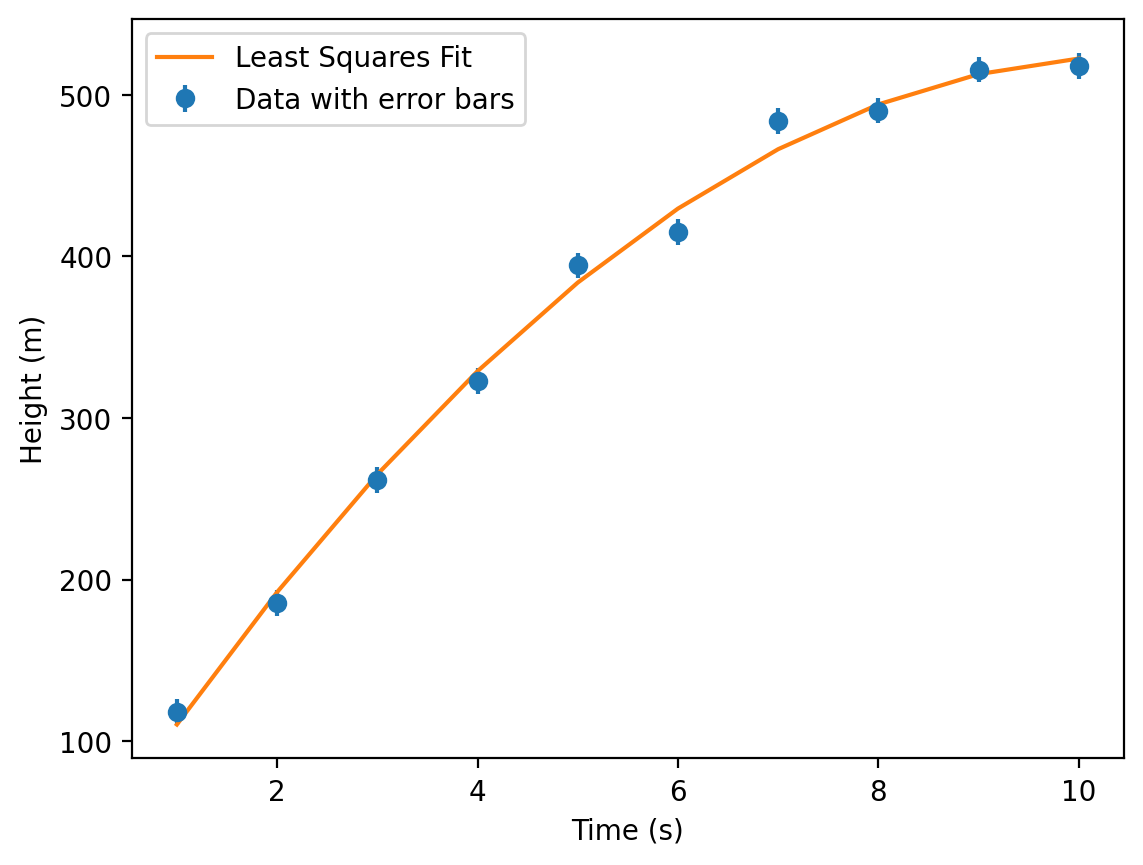

In [5]:
def LS(y, G, Cd=None):
    """
    Least squares (LS) solution for linear regression.
    Params:
        y: The target vector.
        G: The design matrix.
        Cd: The data covariance matrix.
    """
    if Cd is None:
        m = np.linalg.inv(G.T @ G) @ G.T @ y
    else:
        m = np.linalg.inv(G.T @ Cd @ G) @ (G.T @ Cd @ y)
    return m

# Least squares model solution
m_L2 = LS(y, G)
print ("Least Squares solution (2-norm):", np.round(m_L2, 1))

ax = plot_data(t, y, sigma)
ax.legend()
ax.plot(t, G @ m_L2, label='Least Squares Fit')
ax.legend()
plt.show()

The model covariance matrix is
$$
Cov(\mathbf{m}_{L2}) = \sigma^2 (\mathbf{G}^T\mathbf{G})^{-1}.
$$

In [6]:
m_L2_cov = np.linalg.inv(G.T @ G) * sigma**2
print ("L2 model parameters:\n", np.round(m_L2, 1))
print ("L2 model covariance:\n", np.round(m_L2_cov, 1))
m_L2_std = np.sqrt(np.diag(m_L2_cov))
print ("L2 model 95% confidence intervals:\n", np.round(m_L2_std*2, 1))

L2 model parameters:
 [19.3 95.5  9. ]
L2 model covariance:
 [[ 88.5 -33.6  -5.3]
 [-33.6  15.4   2.7]
 [ -5.3   2.7   0.5]]
L2 model 95% confidence intervals:
 [18.8  7.9  1.4]


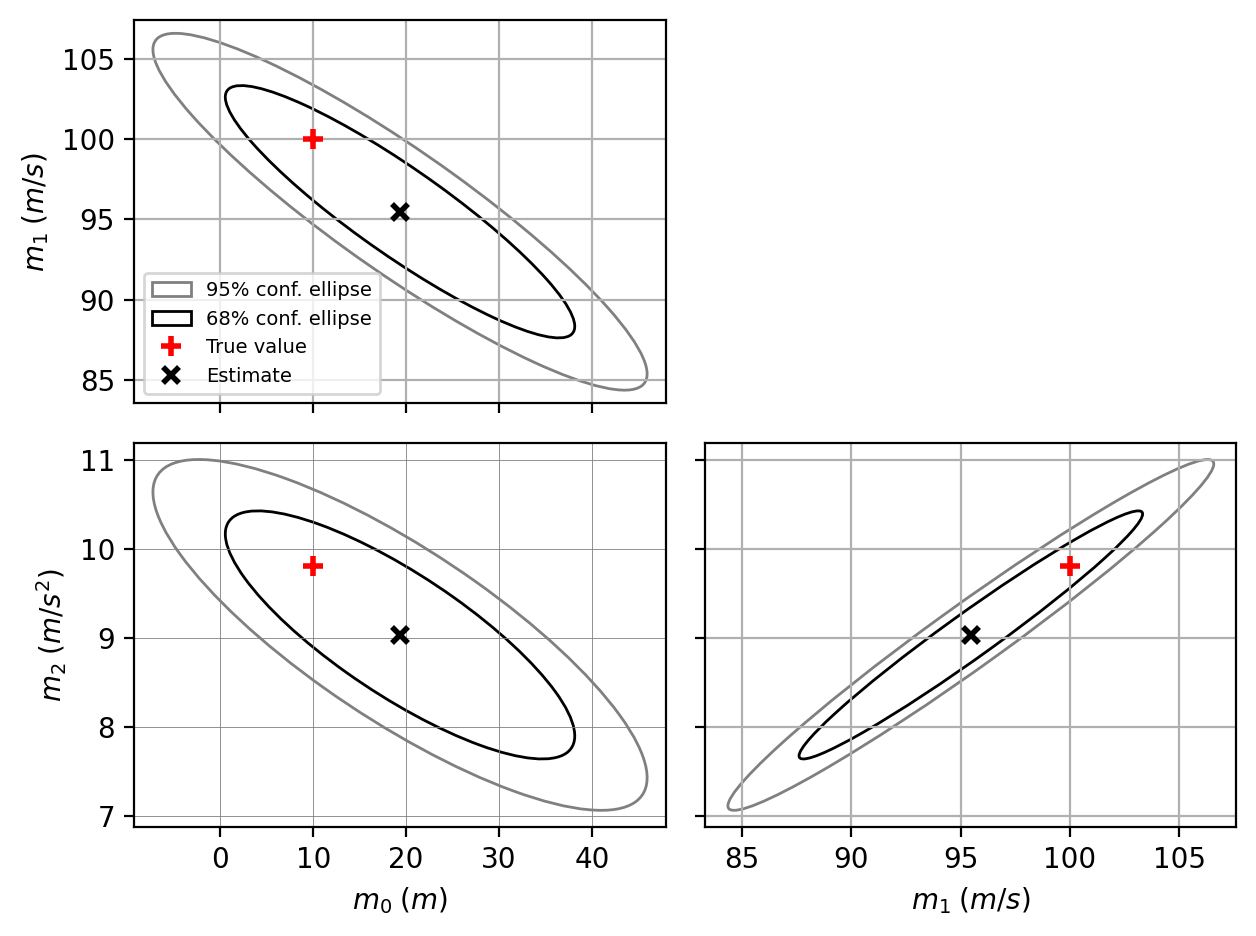

In [7]:
#@title Click to plot model confidence ellipses using $\mathbf{m}_{L2}$ and the estimated covariance matrices.

def plot_ellipse(ax, m, cov, nstd=2, **kwargs):
    """
    Plots an ellipse representing the covariance matrix.
    Params:
        ax: The axis to plot on.
        m: The mean vector.
        cov: The covariance matrix.
        nstd: The number of standard deviations to determine the ellipse's radii.
    """
    from matplotlib.patches import Ellipse
    import matplotlib.transforms as transforms

    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * nstd
    scale_y = np.sqrt(cov[1, 1]) * nstd
    transf = transforms.Affine2D()
    transf.rotate_deg(45)
    transf.scale(scale_x, scale_y)
    transf.translate(m[0], m[1])
    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)

fig, ax = plt.subplots(2, 2, sharex='col', sharey='row')
plot_ellipse(ax[0, 0], m_L2[:2], m_L2_cov[:2, :2]*2, edgecolor='gray', facecolor='none', label='95% conf. ellipse')
plot_ellipse(ax[0, 0], m_L2[:2], m_L2_cov[:2, :2], edgecolor='k', facecolor='none', label='68% conf. ellipse')
ax[0, 0].plot(m_true[0], m_true[1], '+r', label='True value', ms=7, mew=2)
ax[0, 0].plot(m_L2[0], m_L2[1], 'xk', label='Estimate', mew=2)
ax[0, 0].set_ylabel('$m_1\\; (m/s)$')
ax[0, 0].grid()
ax[0, 0].legend(fontsize=7, loc='lower left')

plot_ellipse(ax[1, 1], m_L2[1:], m_L2_cov[1:, 1:]*2, edgecolor='gray', facecolor='none')
plot_ellipse(ax[1, 1], m_L2[1:], m_L2_cov[1:, 1:], edgecolor='k', facecolor='none')
ax[1, 1].plot(m_true[1], m_true[2], '+r', label='True value', ms=7, mew=2)
ax[1, 1].plot(m_L2[1], m_L2[2], 'xk', label='Estimate', mew=2)
ax[1, 1].set_xlabel('$m_1\\; (m/s)$')
ax[1, 1].grid()


plot_ellipse(ax[1, 0], m_L2[[0, 2]], m_L2_cov[[0, 2], :][:, [0, 2]]*2, edgecolor='gray', facecolor='none')
plot_ellipse(ax[1, 0], m_L2[[0, 2]], m_L2_cov[[0, 2], :][:, [0, 2]], edgecolor='k', facecolor='none')
ax[1, 0].grid(lw=.3, color='gray')
ax[1, 0].plot(m_L2[0], m_L2[2], 'xk', label='Estimate', mew=2)
ax[1, 0].plot(m_true[0], m_true[2], '+r', label='True value', ms=7, mew=2)
ax[1, 0].set(xlabel='$m_0\\; (m)$', ylabel='$m_2\\; (m/s^2)$')

ax[0, 1].axis('off')
fig.tight_layout()
plt.show()

To evaluate the goodness of fit to the data, we use $p$-value estimate. It is based on the assumption that the data residuals indeed comply with the normal distribution with $\sigma$ standard deviation.

The $\chi^2$ is estimated from the residual using the $\mathbf{m}_{L2}$ solution,
$$
\chi^2_{obs} = \sum_{i=1}^m \frac{(d_i - (\mathbf{G}\mathbf{m}_{L2})_i)^2}{\sigma^2}.
$$

$\chi^2_{obs}$ has a $\chi^2$ distribution with $\nu = m-n$ degrees of freedom. The $p$-value is the area under the $\chi^2$ curves where $\chi^2 > \chi^2_{obs}$.

The estimated $p$-value for the above example is 0.08, indicating that the recovered model explain the data reasonably well (see Section 2.2; Aster et al., 2019 for more details). Too small $p$-value possibly indicate that either the physcal model is not reasonable or the data noise estimate is inappropriate. $p$-value too close to 1 indicates very good fit to the data.

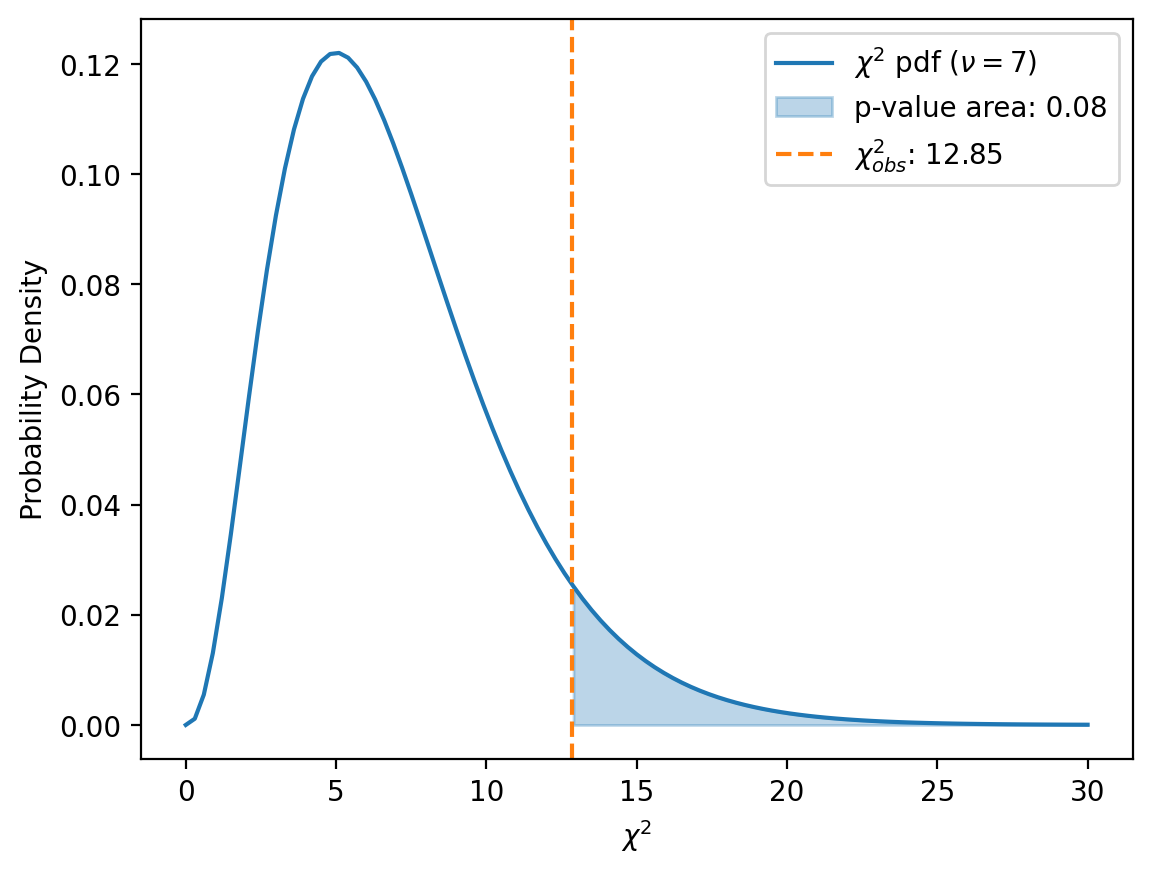

In [8]:
from scipy.stats import chi2

# Compute chi-squared statistic using known sigma
chi2_obs = np.sum((G @ m_L2 - y)**2) / sigma**2
# Degrees of freedom
degrees_of_freedom = len(y) - len(m_L2)
# P-value test
p_value = 1 - chi2.cdf(chi2_obs, df=degrees_of_freedom)


fig, ax = plt.subplots()
x = np.linspace(0, 30, 101)
chi2_pdf = chi2.pdf(x, df=degrees_of_freedom)
ax.plot(x, chi2_pdf, label=f'$\\chi^2$ pdf ($\\nu={degrees_of_freedom}$)')
ax.fill_between(x, 0, chi2_pdf, where=(x > chi2_obs), color='C0', alpha=0.3, label=f'p-value area: {p_value:.2f}')
ax.axvline(chi2_obs, color='C1', linestyle='--', label=f'$\\chi^2_{{obs}}$: {chi2_obs:.2f}')
ax.set(xlabel='$\\chi^2$', ylabel='Probability Density')

ax.legend()
plt.show()

---
## $L1$ regression

The following cell defines the interatively reweighted least squares, or IRLS algorithm to determine the minimum solution of 1-norm misfit.

In [9]:
def IRLS(y, G, epsilon=1e-6, tau=1e-2, max_iter=100):
    """
    Iteratively reweighted least squares (IRLS) for robust L1-regression.
    Params:
        y: The target vector.
        G: The design matrix.
        epsilon: A small value to avoid division by zero.
        tau: Convergence threshold.
        max_iter: Maximum number of iterations.
    """
    # Start with L2 solution as an initial guess
    m = np.linalg.inv(G.T @ G) @ G.T @ y
    for _ in range(max_iter):
        # Data residuals
        r = y - G @ m
        # Water mask tiny residuals to avoid zero division
        r[np.abs(r) < epsilon] = epsilon
        # Weight matrix
        R = np.diag(1 / np.abs(r))
        # Update model
        m_new = LS(y, G, Cd=R)
        # Check for convergence
        if np.linalg.norm(m_new - m) / (1 + np.linalg.norm(m_new)) < tau: break
        m = m_new
    return m

The following example demonstrates severe impacts of a single data outlier on L1 and L2 misfit.

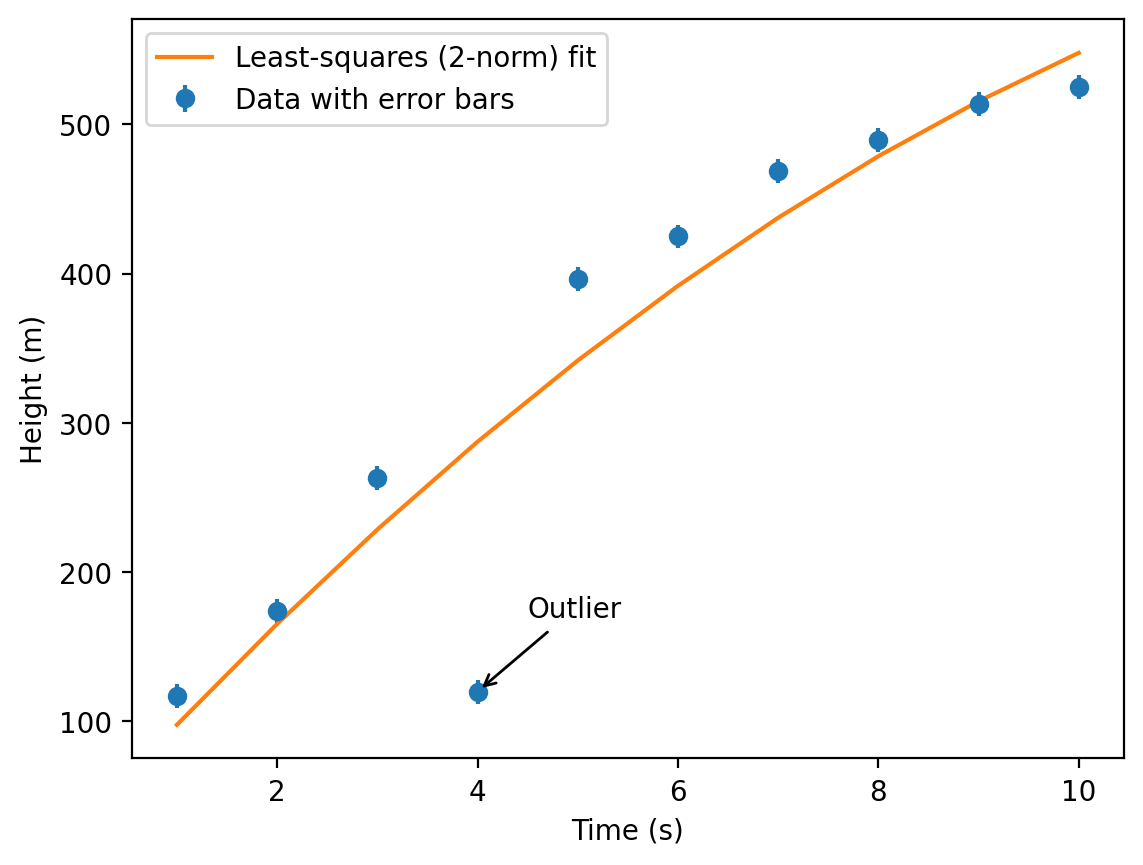

In [10]:
y1 = m_true[0] + m_true[1] * t - 0.5 * m_true[2] * t**2 + np.random.normal(0, sigma, size=t.shape)
y1[3] = 120

ax = plot_data(t, y1, sigma)
m_L2_2 = np.linalg.inv(G.T @ G) @ G.T @ y1
# chi2_obs = np.sum((G @ m_L2 - y1)**2) / sigma**2
# p_value = 1 - chi2.cdf(chi2_obs, df=degrees_of_freedom)
ax.plot(t, G @ m_L2_2, label='Least-squares (2-norm) fit')
ax.annotate(xy=(t[3], y1[3]), xytext=(t[3]+0.5, y1[3]+50), text='Outlier', arrowprops=dict(arrowstyle='->'))

m_L1 = IRLS(y1, G)
# ax.plot(t, G @ m_L1, label='Least 1-norm fit')

ax.legend()
plt.show()

This is the implementation of the $p$-value for L1 norm.

In [11]:
from scipy.stats import norm
def calc_p1_value(mu1, nu):
    sigma1 = np.sqrt((1 - 2/np.pi) * nu)
    gamma = (2 - np.pi/2) / ((np.pi/2 - 1)**1.5 * nu**0.5)
    x = (mu1 - np.sqrt(2/np.pi) * nu) / sigma1
    S_x = norm.cdf(x, scale=sigma1)
    Z2_x = norm.pdf(x) * (x**2 - 1)
    return 1 - S_x + gamma/6 * Z2_x

mu_obs = np.sum(np.abs(G @ m_L1 - y1)) / sigma
p1_value = calc_p1_value(mu_obs, degrees_of_freedom)

print ("L1 Model parameters:", m_L1)
print ("norm-1 p-value:", p1_value)

L1 Model parameters: [26.51081144 91.17382808  8.24454341]
norm-1 p-value: 6.473102808518758e-59


Unlike $L2$-norm, the covariance matrix can not be estimated in an analytical form. The Monte-Carlo method is used to propagate uncertainty from data to model paramters.

In [12]:
## Monte-Carlo method for uncertainty propagation
m_L1_array = []
for _ in range(10000):
    # Generate new data with random realization of data noise
    _y = m_L1[0] + m_L1[1] * t - 0.5 * m_L1[2] * t**2 + np.random.normal(0, sigma, size=t.shape)
    # Estimate model using IRLS with the realized data
    m_L1_array.append(IRLS(_y, G))
m_L1_array = np.array(m_L1_array)
## Estimate covariance matrix from the ensemble of models
m_L1_cov = np.cov(m_L1_array, rowvar=False)

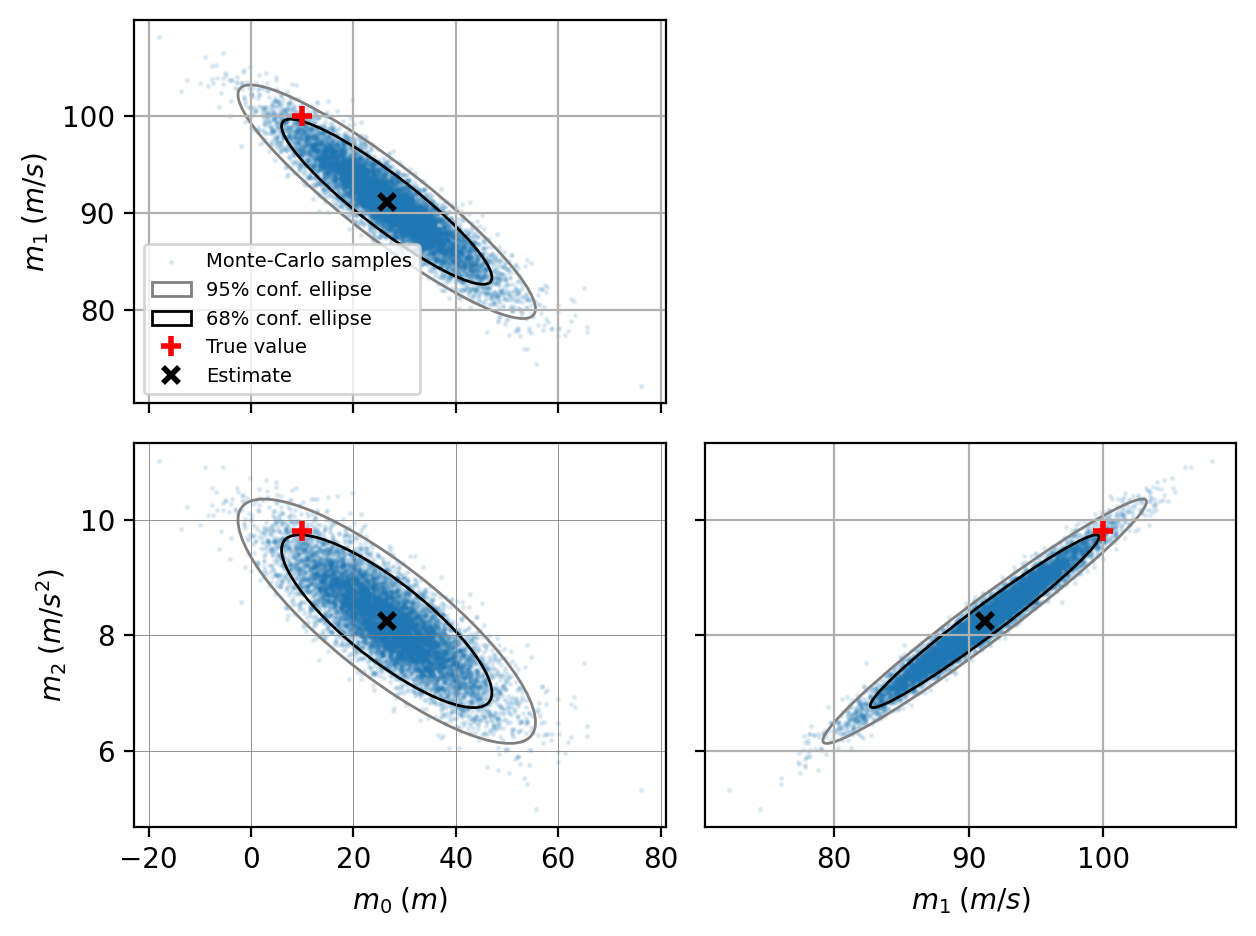

In [13]:
#@title Click to plot model confidence ellipses using $\mathbf{m}_{L1}$ and the estimated covariance matrices.


fig, ax = plt.subplots(2, 2, sharex='col', sharey='row')
ax[0, 0].scatter(m_L1_array[:, 0], m_L1_array[:, 1], s=1, color='C0', alpha=0.1, label='Monte-Carlo samples')
plot_ellipse(ax[0, 0], m_L1[:2], m_L1_cov[:2, :2]*2, edgecolor='gray', facecolor='none', label='95% conf. ellipse')
plot_ellipse(ax[0, 0], m_L1[:2], m_L1_cov[:2, :2], edgecolor='k', facecolor='none', label='68% conf. ellipse')
ax[0, 0].plot(m_true[0], m_true[1], '+r', label='True value', ms=7, mew=2)
ax[0, 0].plot(m_L1[0], m_L1[1], 'xk', label='Estimate', mew=2)
ax[0, 0].set_ylabel('$m_1\\; (m/s)$')
ax[0, 0].grid()
ax[0, 0].legend(fontsize=7, loc='lower left')

ax[1, 1].scatter(m_L1_array[:, 1], m_L1_array[:, 2], s=1, color='C0', alpha=0.1)
plot_ellipse(ax[1, 1], m_L1[1:], m_L1_cov[1:, 1:]*2, edgecolor='gray', facecolor='none')
plot_ellipse(ax[1, 1], m_L1[1:], m_L1_cov[1:, 1:], edgecolor='k', facecolor='none')
ax[1, 1].plot(m_true[1], m_true[2], '+r', label='True value', ms=7, mew=2)
ax[1, 1].plot(m_L1[1], m_L1[2], 'xk', label='Estimate', mew=2)
ax[1, 1].set_xlabel('$m_1\\; (m/s)$')
ax[1, 1].grid()

ax[1, 0].scatter(m_L1_array[:, 0], m_L1_array[:, 2], s=1, color='C0', alpha=0.1)
plot_ellipse(ax[1, 0], m_L1[[0, 2]], m_L1_cov[[0, 2], :][:, [0, 2]]*2, edgecolor='gray', facecolor='none')
plot_ellipse(ax[1, 0], m_L1[[0, 2]], m_L1_cov[[0, 2], :][:, [0, 2]], edgecolor='k', facecolor='none')
ax[1, 0].grid(lw=.3, color='gray')
ax[1, 0].plot(m_L1[0], m_L1[2], 'xk', label='Estimate', mew=2)
ax[1, 0].plot(m_true[0], m_true[2], '+r', label='True value', ms=7, mew=2)
ax[1, 0].set(xlabel='$m_0\\; (m)$', ylabel='$m_2\\; (m/s^2)$')

ax[0, 1].axis('off')
fig.tight_layout()
plt.show()